<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S15/Office_Dataset_MODEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/torchkit')

**Import all Libraries**

In [ ]:
from dataloaders import Data_To_Dataloader
from albtransforms import SingleChannel_ImageTransforms, AlbumentationTransforms
from loss_funcs import *
import lr_finder
from utils import zip_data
from s15_customdataset import DepthMapDataset
from UNet import UNet
from setup import hardware_specs
from trainer import Trainer

**Hardware Properties**

In [ ]:
hardware_specs()

"PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)"

**Unzip the File**

In [ ]:
path = '/content/drive/My Drive/ZipFiles/data_TenK101.zip'
save = '/content/drive/My Drive/Videos'
zip_data(zipfile,path, save)

Outside loop
Extracting ZIP
Zipfile extracted to /content/drive/My Drive/Videos


**Set the path for all 4 type of Images**

In [ ]:
import os
zip_path = "/content/drive/My Drive/ZipExtract/data_TenK101"
subd = os.listdir(zip_path) #Returns sub-directories

bg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG'

bgfg_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG' 

bgfg_mask_path = '/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks'

depthmap_path = '/content/drive/My Drive/ZipExtract/data_TenK101/DepthMaps'


**Some basic checks**

In [ ]:
sorted(os.listdir(bgfg_mask_path))[:-10]

In [ ]:
from PIL import Image
import cv2
img = cv2.imread('/content/drive/My Drive/ZipExtract/data_TenK101/BG_FG Masks/bg_001_fg_001_001.jpeg')
img.shape

(224, 224, 3)

In [ ]:
foldersize=[len(os.listdir(path)) for path in [bg_path, bgfg_path, bgfg_mask_path, depthmap_path]]
foldersize

In [ ]:
mask = sorted([ file for file in os.listdir(bgfg_mask_path)])
mask[:4]



**Dataset Creation**

In [ ]:
# NOTE: Have done a lot of commenting below, because it's tricky.

# Now the first task is to clip input and output
# This is done since BG has only 100 images while BG_FG has around 400K, but for this I'm using 10K
# Now to do this I've used this snippet below, which will clip in the inputs with it's corresponding ground truth

masks = [mask for mask in os.listdir(bgfg_mask_path)] # Mask Files

bg_idx = [int(m.split('_')[1]) for m in masks] # Background file index


bgfiles = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # all 100 BG Files
bg_files = sorted([os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ]) # BG Files of Proper index


**Zipping Data Elements**

In [ ]:
# I have zipped both bg and bg_fg as image segmentation input.
bg_files = sorted([os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ]) # BG Files
bgfg_mask_files = sorted([os.path.join(bgfg_mask_path, mask) for mask in os.listdir(bgfg_mask_path)]) #BGFG MASK Files
bgfg_files = sorted([os.path.join(bgfg_path, bgfg) for bgfg in os.listdir(bgfg_path)]) # BGFG files
dpmap_files = sorted([os.path.join(depthmap_path, map) for map in os.listdir(depthmap_path)]) #DEPTH MAP

s15_data = list(zip(bg_files, bgfg_files, bgfg_mask_files, dpmap_files)) # for bg add rev_bg_files directly and for depth estimation you can add depth maps


**Image Transformations**

In [ ]:
import albumentations as A
import albumentations.pytorch as AP

# BG Images
bg_mean = (0.5411, 0.54, 0.54)
bg_stdev = (0.2320, 0.23, 0.23)

# FG_BG Images
fgbg_mean = (0.513, 0.536, 0.5546)
fgbg_stdev = (0.2355, 0.2317, 0.2326)

# FG Mask Images   # SINGLE CHANNEL
mask_mean = (0.051)
mask_stdev = (0.226)#, 0.4025, 0.4025)

# Depth Maps
dpmap_mean = (0.3045)
dpmap_stdev = (0.1130)

# Used same type of transformations for both Train & Test Data

bg_transform = AlbumentationTransforms([A.Resize(192,192,p=1),
                                                A.Normalize(mean=bg_mean,
                                                std=bg_stdev)])

bgfg_transform = AlbumentationTransforms([A.Resize(192,192,p=1),
                                                # A.HueSaturationValue(p=1),
                                                A.Normalize(mean=fgbg_mean,
                                              std=fgbg_stdev)])

bgfg_mask_transform = SingleChannel_ImageTransforms([A.Resize(192,192,p=1),
                                                    A.Normalize(mean=mask_mean,
                                                    std=mask_stdev)])

dpmap_transform = SingleChannel_ImageTransforms([A.Resize(192,192,p=1),
                                                 A.Normalize(mean=dpmap_mean,
                                                std=dpmap_stdev)])

transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f4bd8c9b828>, <albumentations.augmentations.transforms.Normalize object at 0x7f4bd8c9b8d0>, <albumentations.pytorch.transforms.ToTensor object at 0x7f4bd8c9bd68>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f4bd8c9b898>, <albumentations.augmentations.transforms.Normalize object at 0x7f4bd8c9b438>, <albumentations.pytorch.transforms.ToTensor object at 0x7f4bd8c9bac8>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f4bd8c9b160>, <albumentations.augmentations.transforms.Normalize object at 0x7f4bd8c9b208>, <albumentations.pytorch.transforms.ToTensor object at 0x7f4bd8c9bc18>]
transforms list [<albumentations.augmentations.transforms.Resize object at 0x7f4bd8c9b470>, <albumentations.augmentations.transforms.Normalize object at 0x7f4bd8c9b710>, <albumentations.pytorch.transforms.ToTensor object at 0x7f4bd8c9ba20>]


In [ ]:
_s15 = s15_data[:5001] # using a subset of only 5000 images out of s15_data

In [ ]:
train = DepthMapDataset(_s15[:3500], bg_transform,  bgfg_transform, bgfg_mask_transform, dpmap_transform) #bg_transform,, dpmap_transform)
test = DepthMapDataset(_s15[3501:], bg_transform, bgfg_transform, bgfg_mask_transform, dpmap_transform)

**TRAINLOADER & TESTLOADER**

In [ ]:
trainLoader, testLoader = Data_To_Dataloader(train,test,batch_size=64)

In [ ]:
from torchsummary import summary
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
unet_model = UNet(6,1).to(device)

summary(unet_model, input_size=(6, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]             880
       BatchNorm2d-2         [-1, 16, 192, 192]              32
           Dropout-3         [-1, 16, 192, 192]               0
              ReLU-4         [-1, 16, 192, 192]               0
            Conv2d-5         [-1, 16, 192, 192]           2,320
       BatchNorm2d-6         [-1, 16, 192, 192]              32
           Dropout-7         [-1, 16, 192, 192]               0
              ReLU-8         [-1, 16, 192, 192]               0
        DoubleConv-9         [-1, 16, 192, 192]               0
        MaxPool2d-10           [-1, 16, 96, 96]               0
           Conv2d-11           [-1, 32, 96, 96]           4,640
      BatchNorm2d-12           [-1, 32, 96, 96]              64
          Dropout-13           [-1, 32, 96, 96]               0
             ReLU-14           [-1, 32,

**MODEL TRAINING & EVALUATION**

In [ ]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

unet_model = UNet(6,1).to(device)  # MODEL

# CRITERION PART
depth_c = IoULoss() 
mask_c = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(unet_model.parameters(), lr = 0.01)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=0.001)


# Model Config Class
class ModelConfig:
  def __init__(self, **kwargs):
    for k, v in kwargs.items():
      setattr(self, k, v)


# Model Configs
model_config = ModelConfig(
    cuda = True if torch.cuda.is_available() else False,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    seed = 9091,
    model = unet_model, 
    trainloader = trainLoader,
    testloader = testLoader, 
    lr = 0.01,
    mask_criterion = mask_c,
    depth_criterion = depth_c,
    optimizer = torch.optim.Adam(unet_model.parameters(),lr=0.01),
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True),
    epochs = 10,
    save_model = False,)


In [ ]:

t1 = Trainer(model_config) # Trainer Object
for epoch in range(t1.epochs+1):
  print('EPOCH:', epoch)
  t1.train()
  t1.test()
  if t1.scheduler and isinstance(t1.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
    t1.scheduler.step(t1.test_losses[-1])

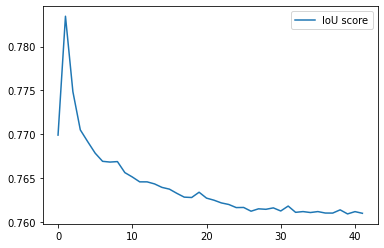

In [ ]:
import matplotlib.pyplot as plt # lr 0.0001
plt.plot(iou_coeffs, label='IoU score')
# plt.plot(valid_losses, label='ssim index')
plt.legend()